In [120]:
# load single fif file

import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from scipy import signal

# load processed fif file
processed_dir = os.path.join('..', '..', 'processed')
resting_files = glob.glob(os.path.join(processed_dir, "*resting_state*.fif"))

raw = mne.io.read_raw_fif(resting_files[60], preload=True)

Opening raw data file ..\..\processed\resting_state_cleaned_63.fif...
    Range : 0 ... 201727 =      0.000 ...   403.454 secs
Ready.
    Range : 0 ... 201727 =      0.000 ...   403.454 secs
Ready.
Reading 0 ... 201727  =      0.000 ...   403.454 secs...
Reading 0 ... 201727  =      0.000 ...   403.454 secs...


C:\Users\JINQI\AppData\Local\Temp\ipykernel_15988\2642207618.py:15: RuntimeWarning: This filename (..\..\processed\resting_state_cleaned_63.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(resting_files[60], preload=True)


In [121]:
events, event_dict = mne.events_from_annotations(raw)

# Get event IDs for close and open eyes conditions
close_eyes_id = event_dict.get('instructed_toCloseEyes')
open_eyes_id = event_dict.get('instructed_toOpenEyes')

# Filter events by event ID (third column)
close_eyes = events[events[:, 2] == close_eyes_id] if close_eyes_id else np.array([])
open_eyes = events[events[:, 2] == open_eyes_id] if open_eyes_id else np.array([])

Used Annotations descriptions: ['boundary', 'break cnt', 'instructed_toCloseEyes', 'instructed_toOpenEyes', 'resting_start']


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Plotting power spectral density (dB=True).
Plotting power spectral density (dB=True).


C:\Users\JINQI\AppData\Local\Temp\ipykernel_15988\1608661317.py:5: UserWarning: Zero value in spectrum for channel Cz
  raw.plot_psd(fmin=1, fmax=50)
C:\Users\JINQI\AppData\Local\Temp\ipykernel_15988\1608661317.py:5: UserWarning: Infinite value in PSD for channel Cz.
These channels might be dead.
  raw.plot_psd(fmin=1, fmax=50)
C:\Users\JINQI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)
C:\Users\JINQI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


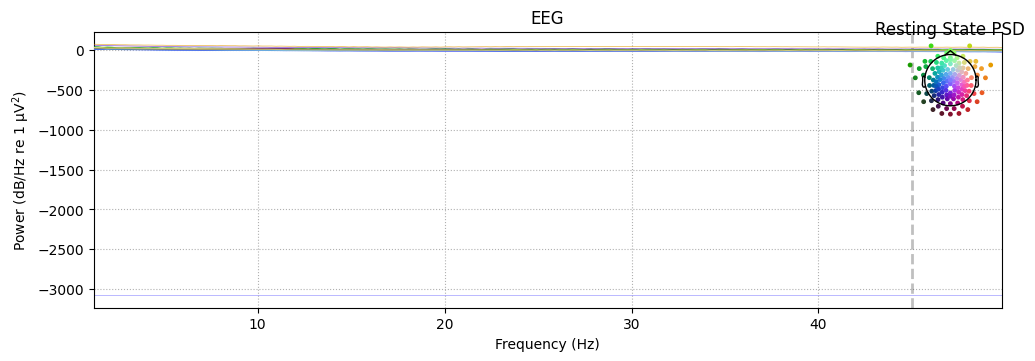

In [122]:
task_1 = close_eyes
task_2 = open_eyes

# plot psd 
raw.plot_psd(fmin=1, fmax=50)
plt.title("Resting State PSD")
plt.show()

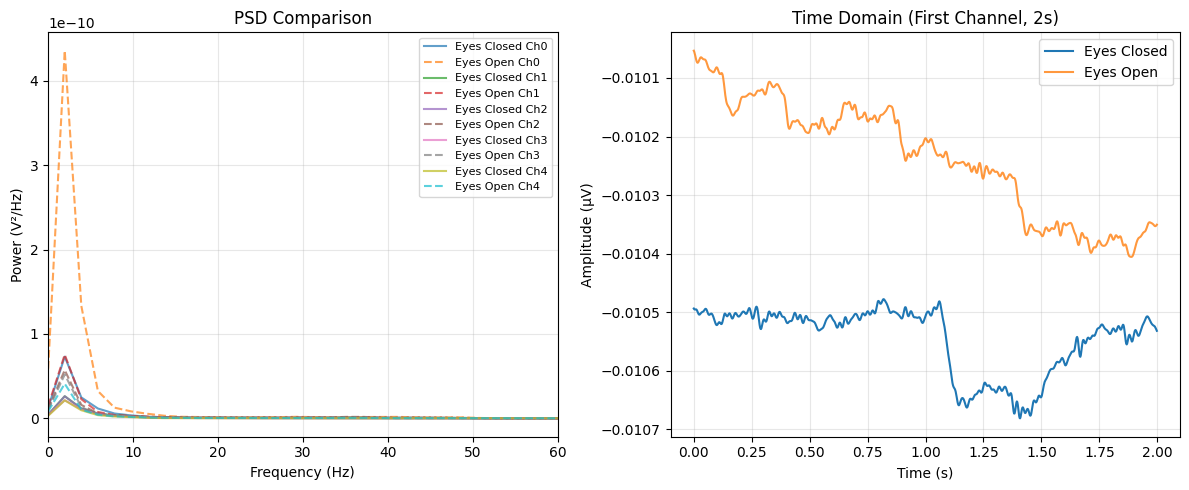

In [ ]:
def plot_psd_comparison(raw, events_1, events_2, duration=10, label_1="Condition 1", label_2="Condition 2", save_path=None):
    """Compare PSD between two conditions (e.g., eyes closed vs eyes open)
    
    Parameters:
    -----------
    raw : mne.io.Raw
        Raw EEG data
    events_1 : np.ndarray
        Events array for first condition
    events_2 : np.ndarray
        Events array for second condition
    duration : float
        Duration in seconds to extract after each event
    label_1, label_2 : str
        Labels for the two conditions
    save_path : str, optional
        Path to save the figure
    """
    from scipy import signal as sg
    
    # Extract data segments
    sfreq = raw.info['sfreq']
    n_samples = int(duration * sfreq)
    
    # Get first event from each condition
    start_1 = events_1[0, 0]
    start_2 = events_2[0, 0]
    
    data_1 = raw.get_data(start=start_1, stop=start_1 + n_samples)
    data_2 = raw.get_data(start=start_2, stop=start_2 + n_samples)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot PSD for first 5 channels (LINEAR SCALE)
    n_channels = min(5, data_1.shape[0])
    for ch in range(n_channels):
        f1, P1 = sg.welch(data_1[ch], fs=sfreq, nperseg=256)
        f2, P2 = sg.welch(data_2[ch], fs=sfreq, nperseg=256)
        axes[0].plot(f1, P1 * 1e12, alpha=0.7, label=f"{label_1} Ch{ch}")
        axes[0].plot(f2, P2 * 1e12, alpha=0.7, ls='--', label=f"{label_2} Ch{ch}")
    
    axes[0].set_title("PSD Comparison")
    axes[0].set_xlabel("Frequency (Hz)")
    axes[0].set_ylabel("Power (µV²/Hz)")
    axes[0].set_xlim(0, 60)
    axes[0].legend(fontsize=8)
    axes[0].grid(alpha=0.3)
    axes[0].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    # Plot time domain (first 2 seconds)
    time_samples = int(2 * sfreq)
    time = np.arange(time_samples) / sfreq
    axes[1].plot(time, data_1[0, :time_samples], label=label_1, lw=1.5)
    axes[1].plot(time, data_2[0, :time_samples], label=label_2, lw=1.5, alpha=0.8)
    axes[1].set_title("Time Domain (First Channel, 2s)")
    axes[1].set_xlabel("Time (s)")
    axes[1].set_ylabel("Amplitude (µV)")
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()

plot_psd_comparison(raw, close_eyes, open_eyes, duration=10, 
                    label_1="Eyes Closed", label_2="Eyes Open")

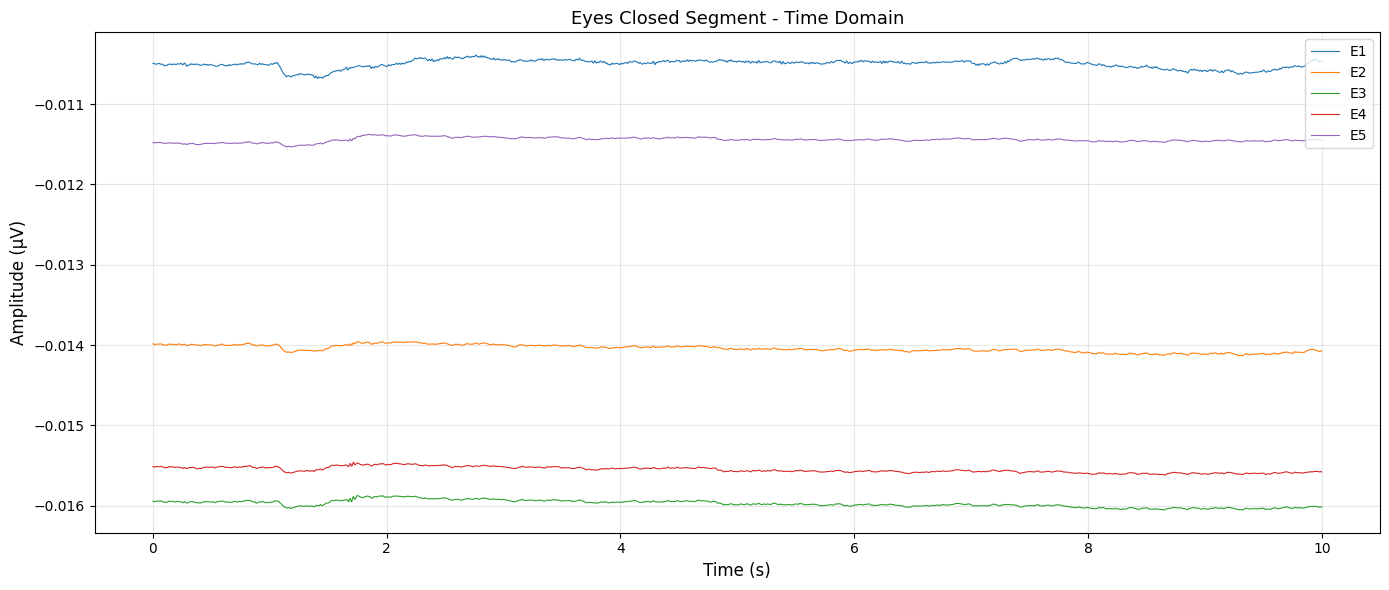

Segment duration: 10s
Sampling frequency: 500.0 Hz
Event start time: 118.93s


In [124]:
# Plot the eyes closed segment
duration = 10  # seconds
sfreq = raw.info['sfreq']
n_samples = int(duration * sfreq)

# Extract data from first eyes closed event
start_sample = close_eyes[0, 0]
data_segment = raw.get_data(start=start_sample, stop=start_sample + n_samples)

# Create time array
time = np.arange(n_samples) / sfreq

# Plot first 5 channels
fig, ax = plt.subplots(figsize=(14, 6))

n_ch_plot = min(5, data_segment.shape[0])
offset = 0
offsets = []

for i in range(n_ch_plot):
    ax.plot(time, data_segment[i] + offset, label=f'{raw.ch_names[i]}', linewidth=0.8)
    offsets.append(offset)
    offset += np.std(data_segment[i]) * 6  # Spacing between channels

ax.set_xlabel('Time (s)', fontsize=12)
ax.set_ylabel('Amplitude (µV)', fontsize=12)
ax.set_title('Eyes Closed Segment - Time Domain', fontsize=13)
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Segment duration: {duration}s")
print(f"Sampling frequency: {sfreq} Hz")
print(f"Event start time: {start_sample/sfreq:.2f}s")

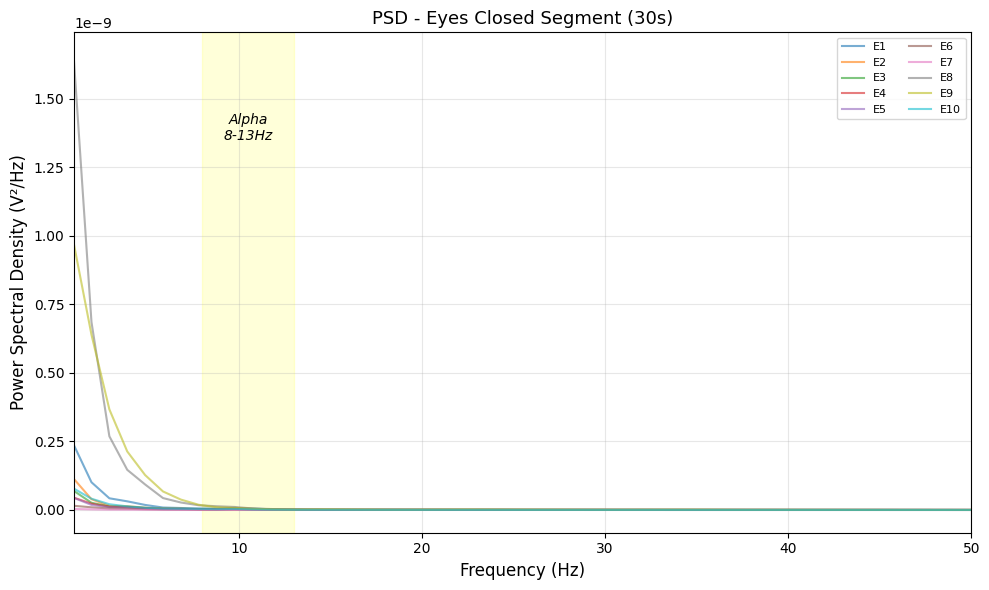


📊 Alpha Power Statistics:
  Mean: 0.000 µV²/Hz
  Std:  0.000 µV²/Hz
  Max:  0.000 µV²/Hz (Channel: E67)


In [ ]:
# Plot PSD of the eyes closed segment
from scipy import signal as sg

duration = 30  # seconds (longer for better frequency resolution)
sfreq = raw.info['sfreq']
n_samples = int(duration * sfreq)

# Extract data from first eyes closed event
start_sample = close_eyes[0, 0]
data_segment = raw.get_data(start=start_sample, stop=start_sample + n_samples)

# Compute PSD for all channels
fig, ax = plt.subplots(figsize=(10, 6))

n_ch_plot = min(10, data_segment.shape[0])
for i in range(n_ch_plot):
    f, Pxx = sg.welch(data_segment[i], fs=sfreq, nperseg=512)
    ax.plot(f, Pxx * 1e12, alpha=0.6, label=f'{raw.ch_names[i]}', linewidth=1.5)

# Highlight alpha band
ax.axvspan(8, 13, alpha=0.15, color='yellow', zorder=0)
ax.text(10.5, ax.get_ylim()[1]*0.8, 'Alpha\n8-13Hz', 
        ha='center', va='center', fontsize=10, style='italic')

ax.set_xlabel('Frequency (Hz)', fontsize=12)
ax.set_ylabel('Power Spectral Density (µV²/Hz)', fontsize=12)
ax.set_title(f'PSD - Eyes Closed Segment ({duration}s)', fontsize=13)
ax.set_xlim(1, 50)
ax.legend(loc='upper right', fontsize=8, ncol=2)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Compute mean alpha power across channels
alpha_powers = []
for i in range(data_segment.shape[0]):
    f, Pxx = sg.welch(data_segment[i], fs=sfreq, nperseg=512)
    alpha_mask = (f >= 8) & (f <= 13)
    alpha_powers.append(np.mean(Pxx[alpha_mask]) * 1e12)

print(f"\n📊 Alpha Power Statistics:")
print(f"  Mean: {np.mean(alpha_powers):.3f} µV²/Hz")
print(f"  Std:  {np.std(alpha_powers):.3f} µV²/Hz")
print(f"  Max:  {np.max(alpha_powers):.3f} µV²/Hz (Channel: {raw.ch_names[np.argmax(alpha_powers)]})")

## Diagnostic: Check Event Timing and Data Quality

If there's no alpha peak, possible issues:
1. **Wrong timing** - Event markers may be offset from actual condition
2. **Transition period** - Capturing the instruction moment, not the settled state
3. **Subject non-compliance** - Eyes weren't actually closed
4. **Data quality** - Excessive artifacts masking alpha

In [126]:
# Diagnostic 1: Check all events and their timing
print("📋 All Events in Recording:")
print("="*70)
for event_name, event_id in event_dict.items():
    event_times = events[events[:, 2] == event_id]
    if len(event_times) > 0:
        print(f"\n{event_name} (ID: {event_id}):")
        print(f"  Count: {len(event_times)}")
        print(f"  Times: {event_times[:, 0] / sfreq} seconds")
        if len(event_times) > 1:
            durations = np.diff(event_times[:, 0]) / sfreq
            print(f"  Durations between events: {durations} seconds")

print("\n" + "="*70)
print(f"\nTotal recording duration: {raw.times[-1]:.1f} seconds")

📋 All Events in Recording:

boundary (ID: 1):
  Count: 1
  Times: [403.454] seconds

break cnt (ID: 2):
  Count: 1
  Times: [0.] seconds

instructed_toCloseEyes (ID: 3):
  Count: 5
  Times: [118.932 178.93  238.93  298.93  358.93 ] seconds
  Durations between events: [59.998 60.    60.    60.   ] seconds

instructed_toOpenEyes (ID: 4):
  Count: 6
  Times: [ 98.932 158.93  218.93  278.93  338.93  398.93 ] seconds
  Durations between events: [59.998 60.    60.    60.    60.   ] seconds

resting_start (ID: 5):
  Count: 1
  Times: [1.798] seconds


Total recording duration: 403.5 seconds


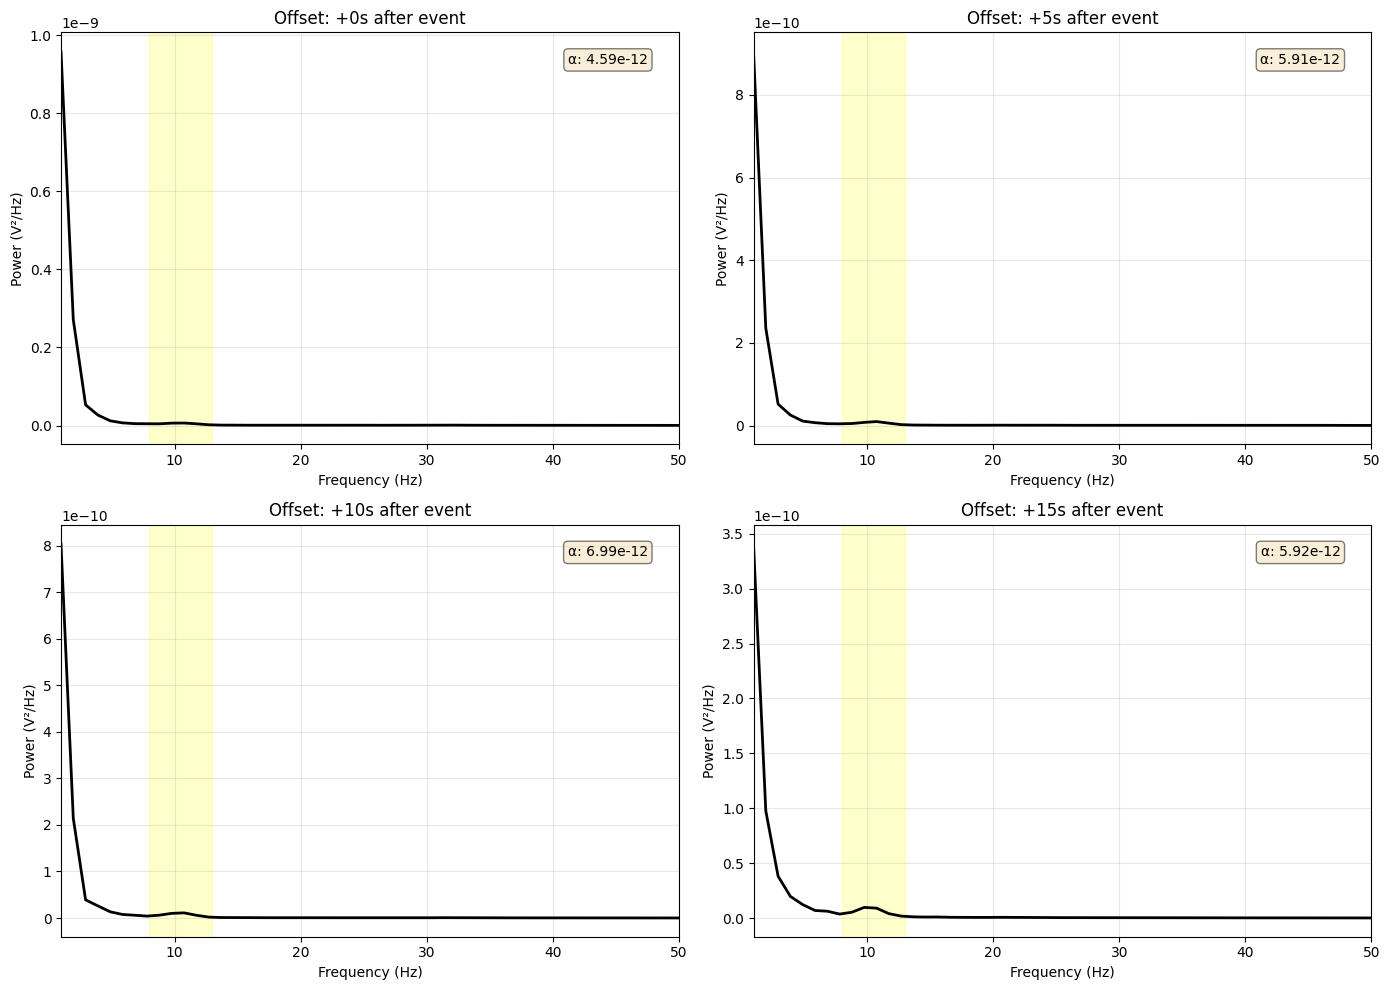


💡 Look for which offset shows the strongest 10 Hz peak
   The event marker might be at the instruction, not the settled state


In [ ]:
# Diagnostic 2: Plot PSD at different time offsets after the event
# Maybe need to skip the transition period (e.g., start 5s after the event)

offsets = [0, 5, 10, 15]  # seconds after event marker
duration = 20  # seconds

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, offset in enumerate(offsets):
    start_sample = close_eyes[0, 0] + int(offset * sfreq)
    n_samples = int(duration * sfreq)
    
    # Check if we have enough data
    if start_sample + n_samples > raw.n_times:
        axes[idx].text(0.5, 0.5, 'Not enough data', ha='center', va='center')
        axes[idx].set_title(f'Offset: +{offset}s (NO DATA)')
        continue
    
    data_segment = raw.get_data(start=start_sample, stop=start_sample + n_samples)
    
    # Average PSD across posterior channels
    n_ch = data_segment.shape[0]
    posterior_chs = range(int(n_ch * 0.8), n_ch)
    
    psd_avg = []
    for ch in posterior_chs:
        f, Pxx = sg.welch(data_segment[ch], fs=sfreq, nperseg=512)
        psd_avg.append(Pxx)
    
    psd_mean = np.mean(psd_avg, axis=0)
    
    axes[idx].plot(f, psd_mean * 1e12, 'k-', linewidth=2)
    axes[idx].axvspan(8, 13, alpha=0.2, color='yellow')
    axes[idx].set_title(f'Offset: +{offset}s after event')
    axes[idx].set_xlabel('Frequency (Hz)')
    axes[idx].set_ylabel('Power (µV²/Hz)')
    axes[idx].set_xlim(1, 50)
    axes[idx].grid(True, alpha=0.3)
    
    # Calculate alpha power
    alpha_mask = (f >= 8) & (f <= 13)
    alpha_power = np.mean(psd_mean[alpha_mask]) * 1e12
    axes[idx].text(0.95, 0.95, f'α: {alpha_power:.3f}', 
                   transform=axes[idx].transAxes, ha='right', va='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n💡 Look for which offset shows the strongest 10 Hz peak")
print("   The event marker might be at the instruction, not the settled state")

In [ ]:
# Diagnostic 3: Compare ALL close_eyes events at +20s offset
print(f"📊 Checking all {len(close_eyes)} eyes-closed segments (20s after event marker):")
print("="*70)

offset = 20  # Start 20 seconds after the event marker
duration = 20
alpha_powers_per_event = []

for i, event in enumerate(close_eyes):
    start = event[0] + int(offset * sfreq)  # Add 20s offset
    n_samples = int(duration * sfreq)
    
    if start + n_samples > raw.n_times:
        print(f"Event {i+1}: Not enough data at +{offset}s offset")
        continue
    
    data = raw.get_data(start=start, stop=start + n_samples)
    
    # Compute average alpha power
    alphas = []
    for ch in range(data.shape[0]):
        f, Pxx = sg.welch(data[ch], fs=sfreq, nperseg=512)
        alpha_mask = (f >= 8) & (f <= 13)
        alphas.append(np.mean(Pxx[alpha_mask]) * 1e12)
    
    mean_alpha = np.mean(alphas)
    alpha_powers_per_event.append(mean_alpha)
    
    event_time = event[0] / sfreq
    actual_time = start / sfreq
    print(f"Event {i+1} (marker: {event_time:.1f}s, analyzed: {actual_time:.1f}s): Alpha = {mean_alpha:.6f} µV²/Hz")

if alpha_powers_per_event:
    best_idx = np.argmax(alpha_powers_per_event)
    print(f"\n✅ Best event: #{best_idx+1} with alpha = {alpha_powers_per_event[best_idx]:.6f} µV²/Hz")
    print(f"   Use: close_eyes[{best_idx}] with +{offset}s offset for analysis")

📊 Checking all 5 eyes-closed segments (20s after event marker):
Event 1 (marker: 118.9s, analyzed: 138.9s): Alpha = 1.837399e-11 V²/Hz
Event 2 (marker: 178.9s, analyzed: 198.9s): Alpha = 2.488411e-11 V²/Hz
Event 1 (marker: 118.9s, analyzed: 138.9s): Alpha = 1.837399e-11 V²/Hz
Event 2 (marker: 178.9s, analyzed: 198.9s): Alpha = 2.488411e-11 V²/Hz
Event 3 (marker: 238.9s, analyzed: 258.9s): Alpha = 7.317152e-11 V²/Hz
Event 4 (marker: 298.9s, analyzed: 318.9s): Alpha = 4.994938e-11 V²/Hz
Event 3 (marker: 238.9s, analyzed: 258.9s): Alpha = 7.317152e-11 V²/Hz
Event 4 (marker: 298.9s, analyzed: 318.9s): Alpha = 4.994938e-11 V²/Hz
Event 5 (marker: 358.9s, analyzed: 378.9s): Alpha = 1.590910e-08 V²/Hz

✅ Best event: #5 with alpha = 1.590910e-08 V²/Hz
   Use: close_eyes[4] with +20s offset for analysis
Event 5 (marker: 358.9s, analyzed: 378.9s): Alpha = 1.590910e-08 V²/Hz

✅ Best event: #5 with alpha = 1.590910e-08 V²/Hz
   Use: close_eyes[4] with +20s offset for analysis


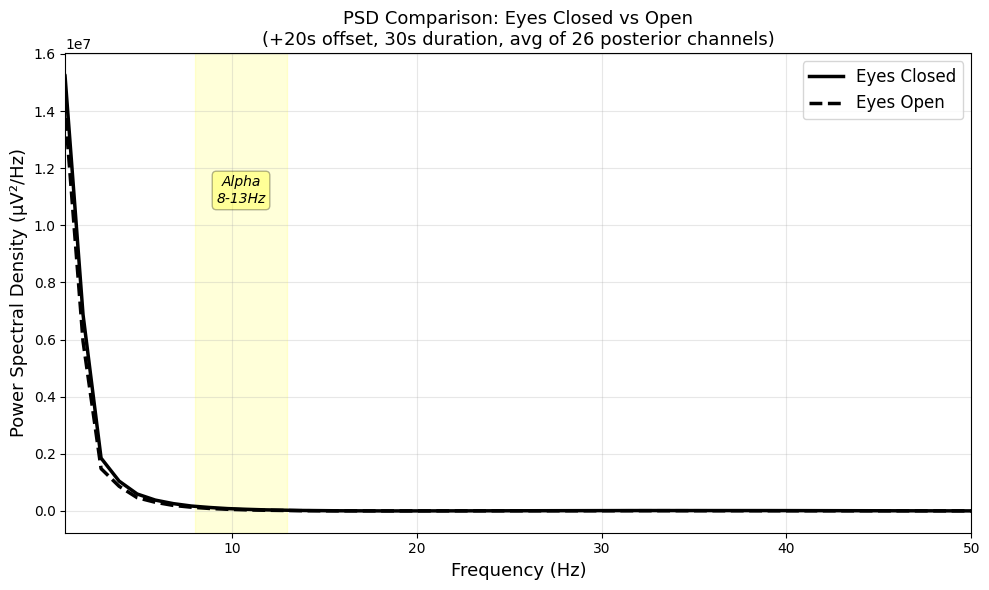


📊 Alpha Band Power (8-13 Hz):
Eyes Closed: 65033.573959 µV²/Hz
Eyes Open:   44485.461400 µV²/Hz
Ratio (Closed/Open): 1.46x
⚠️  MODERATE: Some alpha difference detected

Peak frequency:
  Eyes Closed: 8.79 Hz
  Eyes Open:   8.79 Hz


In [135]:
# Compare eyes closed vs open with 20s offset
from scipy import signal as sg

offset = 20  # seconds after event marker
duration = 30  # seconds of data to analyze
sfreq = raw.info['sfreq']
n_samples = int(duration * sfreq)

# Extract data segments with offset
start_closed = close_eyes[4, 0] + int(offset * sfreq)
start_open = open_eyes[4, 0] + int(offset * sfreq)

data_closed = raw.get_data(start=start_closed, stop=start_closed + n_samples)
data_open = raw.get_data(start=start_open, stop=start_open + n_samples)

# Average PSD across posterior channels
n_ch = data_closed.shape[0]
posterior_chs = range(int(n_ch * 0.8), n_ch)

psd_closed_all = []
psd_open_all = []

for ch in posterior_chs:
    f_c, P_c = sg.welch(data_closed[ch], fs=sfreq, nperseg=512)
    f_o, P_o = sg.welch(data_open[ch], fs=sfreq, nperseg=512)
    psd_closed_all.append(P_c)
    psd_open_all.append(P_o)

psd_closed_mean = np.mean(psd_closed_all, axis=0) * 1e12
psd_open_mean = np.mean(psd_open_all, axis=0) * 1e12

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot solid line for closed, dashed for open
ax.plot(f_c, psd_closed_mean, 'k-', linewidth=2.5, label='Eyes Closed')
ax.plot(f_o, psd_open_mean, 'k--', linewidth=2.5, label='Eyes Open')

# Highlight alpha band
ax.axvspan(8, 13, alpha=0.15, color='yellow', zorder=0)
ax.text(10.5, ax.get_ylim()[1]*0.7, 'Alpha\n8-13Hz', 
        ha='center', va='center', fontsize=10, style='italic',
        bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.3))

ax.set_xlabel('Frequency (Hz)', fontsize=13)
ax.set_ylabel('Power Spectral Density (µV²/Hz)', fontsize=13)
ax.set_title(f'PSD Comparison: Eyes Closed vs Open\n(+{offset}s offset, {duration}s duration, avg of {len(posterior_chs)} posterior channels)', 
             fontsize=13)
ax.set_xlim(1, 50)
ax.legend(loc='upper right', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate alpha power statistics
alpha_mask = (f_c >= 8) & (f_c <= 13)
alpha_closed = np.mean(psd_closed_mean[alpha_mask])
alpha_open = np.mean(psd_open_mean[alpha_mask])
ratio = alpha_closed / alpha_open if alpha_open > 0 else 0

print(f"\n📊 Alpha Band Power (8-13 Hz):")
print(f"=" * 60)
print(f"Eyes Closed: {alpha_closed:.6f} µV²/Hz")
print(f"Eyes Open:   {alpha_open:.6f} µV²/Hz")
print(f"Ratio (Closed/Open): {ratio:.2f}x")
print(f"=" * 60)

if ratio > 2.0:
    print("✅ STRONG: Expected alpha suppression with eyes open")
elif ratio > 1.3:
    print("⚠️  MODERATE: Some alpha difference detected")
else:
    print("❌ WEAK: Little alpha difference - may indicate data quality issues")

# Show peak frequency in alpha band
peak_idx_closed = np.argmax(psd_closed_mean[alpha_mask])
peak_idx_open = np.argmax(psd_open_mean[alpha_mask])
alpha_freqs = f_c[alpha_mask]
print(f"\nPeak frequency:")
print(f"  Eyes Closed: {alpha_freqs[peak_idx_closed]:.2f} Hz")
print(f"  Eyes Open:   {alpha_freqs[peak_idx_open]:.2f} Hz")